In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# Clustering Validation - silhouette_score, Calinski-Harabasz Index

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Clustering Method - Kmean, Hierarchical
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
# IMPORT: Tableau Superstore dataset
data_path = "../sascha/data/superstore_noid.csv"
df = pd.read_csv(data_path)
# CHANGE: to natural format: non-numeric types

# Type Change: 2 columns -> str
df['Customer ID'] = df['Customer ID'].astype("string")
df['Product ID'] = df['Product ID'].astype("string")

# Type Change: 5 columns -> category 
df['Ship Mode'] = df['Ship Mode'].astype("category")
df['Segment'] = df['Segment'].astype("category")
df['Region'] = df['Region'].astype("category")
df['Category'] = df['Category'].astype("category")
df['Sub-Category'] = df['Sub-Category'].astype("category")

# Type Change: 2 columns -> datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
# DEFINE: column types

id_columns = [
    "Customer ID", "Product ID",
]

# Potential target variables
numeric_columns = [
    "Sales", "Quantity", "Discount", "Profit"
]

category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    "Sub-Category" #17
]

void_columns = [
#    "Row ID", 
   "Order ID", "Country"
]

# Customer Name <-> Customer ID
# Product Name <-> Product ID
# [City, State, Postal Code] <-> Region
redundant_columns = [
    "Customer Name", "Product Name", 
    "City", "State", "Postal Code"
]
# ASSIGN: numeric id instead of string id
# Customer Id -> C_id
# Product Id -> P_id

for i in id_columns:
    df[i[0]+'_id'] = df.groupby(i).ngroup()
# DROP: 10 Columns = id + void + redundant
dropping_columns = id_columns + void_columns + redundant_columns

df_f = df.drop(columns=dropping_columns)
# PROFILE: exploratory analysis & save to HTML - uncomment when needed

# import ydata_profiling as yp

# report_super_f = df_f.profile_report()
# report_super_f.to_file(output_file="0409_super_f_report.html")

### 0. Linear Regression

In [3]:
from sklearn import linear_model

In [4]:
sales_099 = df[['Sales']].quantile(q=0.99, numeric_only=True, interpolation='linear')
sales_001 = df[['Sales']].quantile(q=0.01, numeric_only=True,interpolation='linear')

profit_099 = df[['Profit']].quantile(q=0.99, numeric_only=True,interpolation='linear')
profit_001 = df[['Profit']].quantile(q=0.01, numeric_only=True,interpolation='linear')

no_outlier_df = df[df['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df= no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)
df_f


,index,Order Date,Ship Date,Sales,Quantity,Discount,Profit,C_id,P_id,0Ship Mode,...,7Sub-Category,8Sub-Category,9Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,15Sub-Category,16Sub-Category
0,0,2016-11-08,2016-11-11,261.960,2,0.0,41.9136,143,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2016-11-08,2016-11-11,731.940,3,0.0,219.5820,143,55,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-06-12,2016-06-16,14.620,2,0.0,6.8714,237,946,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2015-10-11,2015-10-18,22.368,2,0.2,2.5164,705,1316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,2014-06-09,2014-06-14,48.860,7,0.0,14.1694,88,185,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,9989,2014-01-21,2014-01-23,25.248,3,0.2,4.1028,737,200,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9661,9990,2017-02-26,2017-03-03,91.960,2,0.0,15.6332,190,164,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9662,9991,2017-02-26,2017-03-03,258.576,2,0.2,19.3932,190,1816,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9663,9992,2017-02-26,2017-03-03,29.600,4,0.0,13.3200,190,1247,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,3Sub-Category,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,29.600


In [6]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 2382.22
Coefficient of determination: 0.54


### 1. Order

In [9]:
scaled_df_f = df_cleaned.copy(deep=True)

scaled_df_f[["Sales"]] = StandardScaler().fit_transform(df_cleaned[["Sales"]])
scaled_df_f[["Quantity"]] = StandardScaler().fit_transform(df_cleaned[["Quantity"]])
scaled_df_f[["Profit"]] = StandardScaler().fit_transform(df_cleaned[["Profit"]])

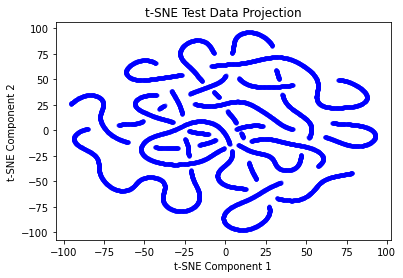

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=2023, perplexity=30)
tsne_df = tsne.fit_transform(scaled_df_f)

# Plot the transformed test data
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c='blue', marker='o', alpha=0.5, s= 10)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Test Data Projection')
plt.show()

In [11]:
number_cluster = 4

kmean = AgglomerativeClustering(n_clusters=number_cluster)

df_cleaned_cluster = df_cleaned.copy(deep=True)
df_cleaned_cluster['Cluster'] = kmean.fit_predict(tsne_df)

X = df_cleaned_cluster[df_cleaned_cluster.columns.difference(["Profit", "index"])]
y = df_cleaned_cluster[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned_cluster[["Profit"]].loc[X['Cluster'] == i])
    

In [12]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
    X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
    X_train_.append(X_train)
    X_test_.append(X_test)
    y_train_.append(y_train)
    y_test_.append(y_test)
    
    if(len(y_train) and len(y_test)):
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))


Mean squared error of 0 : 2313.03
Coefficient of determination of 0 : 0.56
Mean squared error of 1 : 2859.10
Coefficient of determination of 1 : 0.50
Mean squared error of 2 : 1910.59
Coefficient of determination of 2 : 0.60
Mean squared error of 3 : 2408.81
Coefficient of determination of 3 : 0.63


In [13]:
number_cluster = 4

kmean = AgglomerativeClustering(n_clusters=number_cluster)

df_cleaned_cluster = df_cleaned.copy(deep=True)
df_cleaned_cluster['Cluster'] = kmean.fit_predict(df_cleaned)

X = df_cleaned_cluster[df_cleaned_cluster.columns.difference(["Profit", "index"])]
y = df_cleaned_cluster[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned_cluster[["Profit"]].loc[X['Cluster'] == i])
    

In [14]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
       
    if(len(y_[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
        X_train_.append(X_train)
        X_test_.append(X_test)
        y_train_.append(y_train)
        y_test_.append(y_test)
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))
    else:
        X_train_.append(0)
        X_test_.append(0)
        y_train_.append(0)
        y_test_.append(0)


Mean squared error of 0 : 2332.82
Coefficient of determination of 0 : 0.63
Mean squared error of 1 : 2988.38
Coefficient of determination of 1 : 0.50
Mean squared error of 2 : 1859.28
Coefficient of determination of 2 : 0.53
Mean squared error of 3 : 2483.65
Coefficient of determination of 3 : 0.48


### 2. Product - Sales, Quantity, Discount, Profit, Category

In [15]:
columns_drop = [
    "Order ID",
    "Ship Date",
    "Ship Mode",
    "Customer ID",
    "Customer Name",
    "Segment",
    "Country",
    "City",
    "State",
    "Postal Code",
    "Region",
    "Sub-Category",
    "Product Name",
    "Order Date",
]
df_cleaned = df.drop(columns=columns_drop)

df_cleaned['Discount Amount'] = df_cleaned['Sales'] * df_cleaned['Discount']
grouped_df = df_cleaned.groupby(['Product ID', 'Category']).agg(
    {
        'Sales': 'sum',
        'Quantity': 'sum',
        'Discount Amount': 'sum',
        'Profit': 'sum',
    }
).reset_index()

# One-hot encode Category
grouped_df_encoded = pd.get_dummies(grouped_df, columns=['Category'])

# Normalize the numerical attributes
scaler = StandardScaler()
numeric_columns = ['Sales', 'Quantity', 'Discount Amount', 'Profit']
grouped_df_encoded[numeric_columns] = scaler.fit_transform(grouped_df_encoded[numeric_columns])

# Perform K-means clustering
kmean = AgglomerativeClustering(n_clusters=number_cluster)
grouped_df_encoded['Cluster'] = kmean.fit_predict(grouped_df_encoded.iloc[:, 1:])

# Add cluster labels back to the original dataframe
grouped_df['Cluster'] = grouped_df_encoded['Cluster']


In [16]:
grouped_df

,Product ID,Category,Sales,Quantity,Discount Amount,Profit,Cluster
0,FUR-BO-10000112,Furniture,825.174,9,247.5522,-117.8820,2
1,FUR-BO-10000112,Office Supplies,0.000,0,0.0000,0.0000,1
2,FUR-BO-10000112,Technology,0.000,0,0.0000,0.0000,1
3,FUR-BO-10000330,Furniture,1064.624,10,123.3996,24.1960,2
4,FUR-BO-10000330,Office Supplies,0.000,0,0.0000,0.0000,1
...,...,...,...,...,...,...,...
5581,TEC-PH-10004959,Office Supplies,0.000,0,0.0000,0.0000,1
5582,TEC-PH-10004959,Technology,341.666,4,48.2352,40.1960,1
5583,TEC-PH-10004977,Furniture,0.000,0,0.0000,0.0000,1
5584,TEC-PH-10004977,Office Supplies,0.000,0,0.0000,0.0000,1


In [17]:
df_cluster = df.copy(deep=True)

for i in range(number_cluster):
    df_cluster.loc[df_cluster['Product ID'].isin(list(grouped_df.loc[grouped_df['Cluster'] == i]['Product ID'])), 'Cluster'] = int(i)

In [18]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4,29.600


In [19]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned[["Profit"]].loc[X['Cluster'] == i])


In [20]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
       
    if(len(y_[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
        X_train_.append(X_train)
        X_test_.append(X_test)
        y_train_.append(y_train)
        y_test_.append(y_test)
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))
    else:
        X_train_.append(0)
        X_test_.append(0)
        y_train_.append(0)
        y_test_.append(0)


Mean squared error of 1 : 5194.34
Coefficient of determination of 1 : 0.57
Mean squared error of 2 : 1571.54
Coefficient of determination of 2 : 0.45


### 3. Customer - Recency, Frequency, Sales

In [21]:
# Calculate Recency, Frequency, and Monetary (RFM) values
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum'
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
})

# Normalize RFM values and apply K-means clustering
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm)
Spectral = AgglomerativeClustering(n_clusters=number_cluster)
rfm['Cluster'] = Spectral.fit_predict(rfm_normalized)

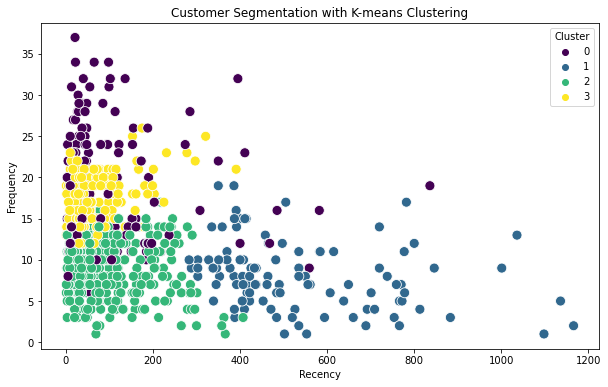

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation with K-means Clustering')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

In [23]:
df_cluster = df.copy(deep=True)

for i in range(number_cluster):
    df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == i].index.values)), 'Cluster'] = int(i)

In [24]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,29.600


In [25]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned[["Profit"]].loc[X['Cluster'] == i])


In [26]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
       
    if(len(y_[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
        X_train_.append(X_train)
        X_test_.append(X_test)
        y_train_.append(y_train)
        y_test_.append(y_test)
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))
    else:
        X_train_.append(0)
        X_test_.append(0)
        y_train_.append(0)
        y_test_.append(0)


Mean squared error of 0 : 3666.29
Coefficient of determination of 0 : 0.50
Mean squared error of 1 : 4547.64
Coefficient of determination of 1 : 0.05
Mean squared error of 2 : 2431.48
Coefficient of determination of 2 : 0.51
Mean squared error of 3 : 2057.28
Coefficient of determination of 3 : 0.52


### 4. Customer - Recency, Frequency, Sales, Quantity, Discount, Profit

In [27]:
number_cluster = 4

# Calculate Recency, Frequency, and Monetary (RFM) values
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum',
    'Profit': 'sum'
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Sales',
    'Quantity': 'Quantity',
    'Discount': 'Discount',
    'Profit': 'Profit'
})

# Normalize RFM values and apply K-means clustering
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm)
Spectral = AgglomerativeClustering(n_clusters=number_cluster)
rfm['Cluster'] = Spectral.fit_predict(rfm_normalized)

In [28]:
rfm

,Recency,Frequency,Sales,Quantity,Discount,Profit,Cluster
Customer ID,,,,,,,
AA-10315,185,11,5563.560,30,1.00,-362.8825,3
AA-10375,20,15,1056.390,41,1.20,277.3824,3
AA-10480,260,12,1790.512,36,0.20,435.8274,3
AA-10645,56,18,5086.935,64,1.15,857.8033,0
AB-10015,416,6,886.156,13,0.40,129.3465,2
...,...,...,...,...,...,...,...
XP-21865,44,28,2374.658,100,1.30,621.2300,0
YC-21895,5,8,5454.350,31,0.60,1305.6290,3
YS-21880,10,12,6720.444,58,0.60,1778.2923,1


In [29]:
df_cluster = df.copy(deep=True)

for i in range(number_cluster):
    df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == i].index.values)), 'Cluster'] = int(i)

In [30]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,29.600


In [31]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned[["Profit"]].loc[X['Cluster'] == i])


In [32]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
       
    if(len(y_[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
        X_train_.append(X_train)
        X_test_.append(X_test)
        y_train_.append(y_train)
        y_test_.append(y_test)
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))
    else:
        X_train_.append(0)
        X_test_.append(0)
        y_train_.append(0)
        y_test_.append(0)


Mean squared error of 0 : 2723.81
Coefficient of determination of 0 : 0.37
Mean squared error of 1 : 6507.03
Coefficient of determination of 1 : 0.51
Mean squared error of 2 : 3368.98
Coefficient of determination of 2 : 0.51
Mean squared error of 3 : 2134.21
Coefficient of determination of 3 : 0.52


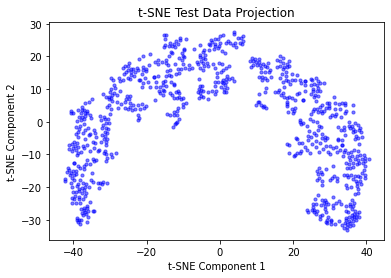

In [38]:

# Calculate Recency, Frequency, and Monetary (RFM) values
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'count',
    'Sales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum',
    'Profit': 'sum'
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Sales',
    'Quantity': 'Quantity',
    'Discount': 'Discount',
    'Profit': 'Profit'
})


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=2023, perplexity=30)
tsne_df = tsne.fit_transform(rfm)

# Plot the transformed test data
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c='blue', marker='o', alpha=0.5, s= 10)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Test Data Projection')
plt.show()

# Normalize RFM values and apply K-means clustering
#scaler = StandardScaler()
#rfm_normalized = scaler.fit_transform(tsne_df)



Spectral = AgglomerativeClustering(n_clusters=number_cluster)
rfm['Cluster'] = Spectral.fit_predict(tsne_df)

In [39]:
df_cluster = df.copy(deep=True)

for i in range(number_cluster):
    df_cluster.loc[df_cluster['Customer ID'].isin(list(rfm.loc[rfm['Cluster'] == i].index.values)), 'Cluster'] = int(i)

In [40]:
no_outlier_df = df_cluster[df_cluster['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df = no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables


df_f = df_f.drop(category_columns, axis=1)

columns_to_drop = [
    "Order Date",
    "Ship Date",
    "C_id",
    "P_id"
]

# Drop the specified columns
df_cleaned = df_f.drop(columns=columns_to_drop)

#df_cleaned
df_cleaned[["Profit"]]
df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]

,0Category,0Region,0Segment,0Ship Mode,0Sub-Category,10Sub-Category,11Sub-Category,12Sub-Category,13Sub-Category,14Sub-Category,...,4Sub-Category,5Sub-Category,6Sub-Category,7Sub-Category,8Sub-Category,9Sub-Category,Cluster,Discount,Quantity,Sales
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,261.960
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,731.940
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,14.620
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,2,22.368
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,7,48.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.2,3,25.248
9661,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2,91.960
9662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,2,258.576
9663,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4,29.600


In [41]:
X = df_cleaned[df_cleaned.columns.difference(["Profit", "index"])]
y = df_cleaned[["Profit"]]

X_=[]
y_=[]

for i in range(number_cluster):
    X_.append(X.loc[X['Cluster'] == i])
    y_.append(df_cleaned[["Profit"]].loc[X['Cluster'] == i])


In [42]:
reg_=[]
X_train_=[]
X_test_=[]
y_train_=[]
y_test_=[]

for i in range(number_cluster):
    reg_.append(linear_model.LinearRegression())
       
    if(len(y_[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_[i], y_[i], test_size=0.2, random_state=42)
        X_train_.append(X_train)
        X_test_.append(X_test)
        y_train_.append(y_train)
        y_test_.append(y_test)
        reg_[-1].fit(X_train, y_train)
        y_pred = reg_[-1].predict(X_test)
        print("Mean squared error of", i, ": %.2f" % mean_squared_error(y_test, y_pred))
        print("Coefficient of determination of", i, ": %.2f" % r2_score(y_test, y_pred))
    else:
        X_train_.append(0)
        X_test_.append(0)
        y_train_.append(0)
        y_test_.append(0)


Mean squared error of 0 : 2571.51
Coefficient of determination of 0 : 0.52
Mean squared error of 1 : 1514.21
Coefficient of determination of 1 : 0.48
Mean squared error of 2 : 3129.71
Coefficient of determination of 2 : 0.55
Mean squared error of 3 : 313.00
Coefficient of determination of 3 : 0.34
